## PROBLEM STATEMENT
Identify where users drop in the marketing funnel, compare channel-wise performance, and suggest actions to improve lead-to-customer conversion.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
df = pd.read_csv('Data/Funnel_Analysis_Data.csv')

In [44]:
df.head()

,User ID,Session ID,Event Time,Event,Device,Region,Channel,Product Category,Revenue,Bonus Flag
0,USR-00001,SES-00001,2026-01-07 23:46:20.358501,Browse,Tablet,South,Organic,Electronics,0.0,Yes
1,USR-00001,SES-00001,2026-01-07 23:49:20.358501,Add to Cart,Tablet,South,Organic,Electronics,0.0,Yes
2,USR-00001,SES-00001,2026-01-07 23:51:20.358501,Checkout,Tablet,South,Organic,Electronics,0.0,Yes
3,USR-00002,SES-00002,2026-01-04 21:06:42.296010,Browse,Desktop,East,Email,Sports,0.0,Yes
4,USR-00002,SES-00002,2026-01-04 21:10:42.296010,Add to Cart,Desktop,East,Email,Sports,0.0,Yes


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21409 entries, 0 to 21408
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User ID           21409 non-null  object 
 1   Session ID        21409 non-null  object 
 2   Event Time        21409 non-null  object 
 3   Event             21409 non-null  object 
 4   Device            21409 non-null  object 
 5   Region            21409 non-null  object 
 6   Channel           21409 non-null  object 
 7   Product Category  21409 non-null  object 
 8   Revenue           21409 non-null  float64
 9   Bonus Flag        21409 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.6+ MB


In [46]:
df =df.drop(columns=['Event Time', 'Device', 'Bonus Flag'])

In [47]:
df.isnull().sum()

User ID             0
Session ID          0
Event               0
Region              0
Channel             0
Product Category    0
Revenue             0
dtype: int64

In [48]:
df.duplicated().sum()

0

In [49]:
df['Event'].value_counts()


Event
Browse         10000
Add to Cart     6949
Checkout        3456
Purchase        1004
Name: count, dtype: int64

In [50]:
df['Event'] = df['Event'].str.lower().str.strip()


In [52]:
event_map = {
    'browse': 'Visit',
    'add to cart': 'Lead',
    'checkout': 'Qualified Lead',
    'purchase': 'Customer'
}

df['Funnel_Stage'] = df['Event'].map(event_map)


In [53]:
df['Funnel_Stage'].value_counts()


Funnel_Stage
Visit             10000
Lead               6949
Qualified Lead     3456
Customer           1004
Name: count, dtype: int64

In [54]:
overall_funnel = (
    df.groupby('Funnel_Stage')['User ID']
    .nunique()
    .reset_index(name='users')
)


In [56]:
overall_funnel

,Funnel_Stage,users
0,Customer,1004
1,Lead,6949
2,Qualified Lead,3456
3,Visit,10000


In [57]:
df.groupby(['Channel','Funnel_Stage'])['User ID'].nunique()


Channel       Funnel_Stage  
Email         Customer           248
              Lead              1762
              Qualified Lead     879
              Visit             2515
Google Ads    Customer           268
              Lead              1746
              Qualified Lead     893
              Visit             2520
Organic       Customer           239
              Lead              1745
              Qualified Lead     866
              Visit             2528
Social Media  Customer           249
              Lead              1696
              Qualified Lead     818
              Visit             2437
Name: User ID, dtype: int64

Email example:

Visit → Lead
= 1762 / 2515 ≈ 70%

Lead → Qualified Lead
= 879 / 1762 ≈ 50%

Qualified Lead → Customer
= 248 / 879 ≈ 28%

## PYTHON ME CONVERSION NIKALNA

In [58]:
channel_funnel = (
    df.groupby(['Channel','Funnel_Stage'])['User ID']
    .nunique()
    .reset_index(name='users')
)

In [59]:
stages = ['Visit','Lead','Qualified Lead','Customer']

In [60]:

channel_funnel['Funnel_Stage'] = pd.Categorical(
    channel_funnel['Funnel_Stage'],
    categories=stages,
    ordered=True
)

In [61]:
channel_funnel = channel_funnel.sort_values(
    ['Channel','Funnel_Stage']
)

In [62]:
channel_funnel

,Channel,Funnel_Stage,users
3,Email,Visit,2515
1,Email,Lead,1762
2,Email,Qualified Lead,879
0,Email,Customer,248
7,Google Ads,Visit,2520
5,Google Ads,Lead,1746
6,Google Ads,Qualified Lead,893
4,Google Ads,Customer,268
11,Organic,Visit,2528
9,Organic,Lead,1745


In [63]:
channel_funnel['prev_users'] = (
    channel_funnel.groupby('Channel')['users'].shift(1)
)

In [64]:
channel_funnel['conversion_rate'] = (
    channel_funnel['users'] / channel_funnel['prev_users']
)

In [65]:
channel_funnel

,Channel,Funnel_Stage,users,prev_users,conversion_rate
3,Email,Visit,2515,NaN,NaN
1,Email,Lead,1762,2515.0,0.700596
2,Email,Qualified Lead,879,1762.0,0.498865
0,Email,Customer,248,879.0,0.282139
7,Google Ads,Visit,2520,NaN,NaN
5,Google Ads,Lead,1746,2520.0,0.692857
6,Google Ads,Qualified Lead,893,1746.0,0.511455
4,Google Ads,Customer,268,893.0,0.300112
11,Organic,Visit,2528,NaN,NaN
9,Organic,Lead,1745,2528.0,0.690269


Top funnel (Visit → Lead) ≈ 69–70% 

Mid funnel (Lead → Checkout) ≈ 48–51% 

Bottom funnel (Checkout → Purchase) ≈ 27–30%

Problem traffic ka nahi hai, problem conversion ka hai

Q: Where is the biggest drop-off?

A: Checkout → Purchase

Q: Which channel performs best?

A: Social Media (highest final conversion)

Q: Which channel needs improvement?

A: Organic (lowest final conversion)

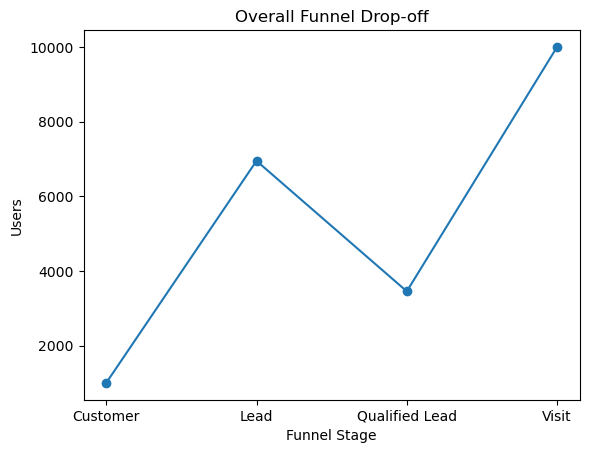

In [66]:
import matplotlib.pyplot as plt

overall = overall_funnel.sort_values('Funnel_Stage')

plt.figure()
plt.plot(overall['Funnel_Stage'], overall['users'], marker='o')
plt.title("Overall Funnel Drop-off")
plt.xlabel("Funnel Stage")
plt.ylabel("Users")
plt.show()


The funnel analysis shows a significant drop-off at the checkout to purchase stage, indicating friction in the final conversion step.

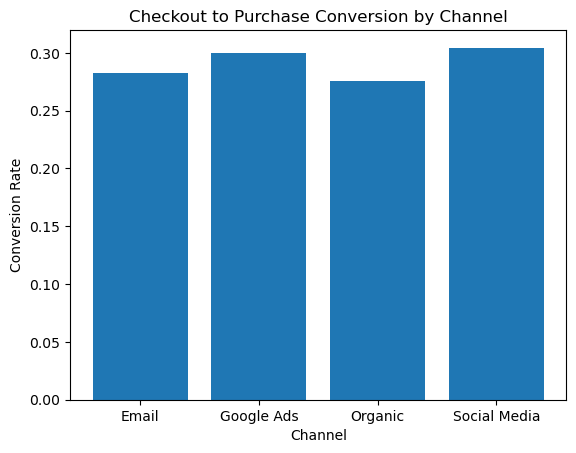

In [67]:
final_stage = channel_funnel[channel_funnel['Funnel_Stage'] == 'Customer']

plt.figure()
plt.bar(final_stage['Channel'], final_stage['conversion_rate'])
plt.title("Checkout to Purchase Conversion by Channel")
plt.xlabel("Channel")
plt.ylabel("Conversion Rate")
plt.show()


Social Media and Google Ads exhibit slightly higher final-stage conversion compared to Organic traffic.

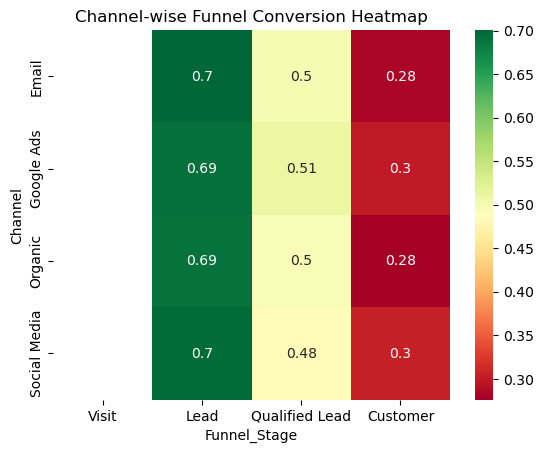

In [68]:
import seaborn as sns

pivot = channel_funnel.pivot(
    index='Channel',
    columns='Funnel_Stage',
    values='conversion_rate'
)

plt.figure()
sns.heatmap(pivot, annot=True, cmap='RdYlGn')
plt.title("Channel-wise Funnel Conversion Heatmap")
plt.show()


The heatmap reveals that the checkout stage is consistently the weakest point across all channels.

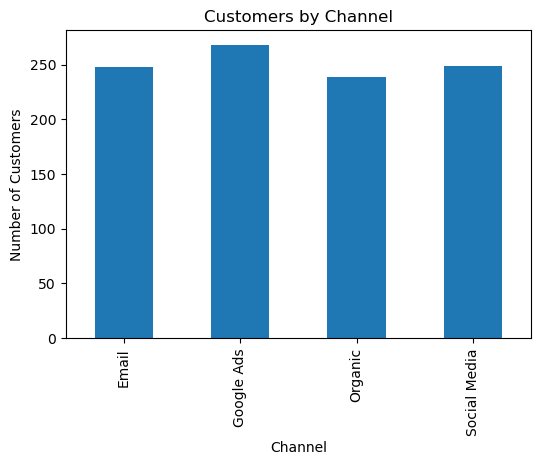

In [70]:
customers = df[df['Funnel_Stage'] == 'Customer']

cust_count = customers.groupby('Channel')['User ID'].nunique()

plt.figure(figsize=(6,4))
cust_count.plot(kind='bar')
plt.title("Customers by Channel")
plt.ylabel("Number of Customers")
plt.show()


Google Ads generates the highest number of customers, while Organic traffic underperforms in final conversion.